In [99]:
import pandas as pd
import numpy as np
import random as rand

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from pmdarima import auto_arima #!pip install pmdarima
import pmdarima as pm

from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf,plot_predict

from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf

from scipy import stats as sps
from scipy.interpolate import interp1d
import scipy.stats

from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping

from IPython.display import clear_output

from datetime import timedelta
from time import time

font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   :  8}

mpl.rc('font', **font)

mpl.rcParams['axes.grid']=True
plt.rcParams.update({'figure.figsize':(9, 7), 'figure.dpi':120})

mpl.rcParams['axes.grid']=True
pd.options.display.max_rows = 999


In [85]:
########################################################## Import Data #########################################################
infy_stock_df = pd.read_csv('data/infy_stock.csv')
nifty_index_df = pd.read_csv('data/nifty_it_index.csv')
tcs_stock_df = pd.read_csv('data/tcs_stock.csv')

def prepare(df, name):
    res = df[['Date',name]]
    res['Date'] = pd.to_datetime(res['Date'])
    res = res.set_index('Date')
    res.columns = [name]
    return res

infy_stock_df = prepare(infy_stock_df, 'Close')
nifty_index_df = prepare(nifty_index_df, 'Close')
tcs_stock_df = prepare(tcs_stock_df, 'Close')


C:\Users\licho\AppData\Local\Temp\ipykernel_5544\3787877439.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['Date'] = pd.to_datetime(res['Date'])
C:\Users\licho\AppData\Local\Temp\ipykernel_5544\3787877439.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['Date'] = pd.to_datetime(res['Date'])
C:\Users\licho\AppData\Local\Temp\ipykernel_5544\3787877439.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [86]:
############################################################ Plot ##############################################################
############################################################ Plot - LSTM ########################################################
def plot2series(df, split, col = 'Close', title = ' ', save_name = 'img'):
    df1 = df.iloc[0:split, :]
    df2 = df.iloc[split - 1:,:]
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    
    
    plt.plot(df1[col], color = 'red', linewidth=2, markersize=6, label = 'Actual Data')
    plt.plot(df2[col], color = 'green', linewidth=2, markersize=6, label = 'Predicted Data')

    ci = 1.96 * df2[col].std()/df2[col].mean()

    plt.fill_between(df2.index.get_level_values('Date'), 
                    (df2[col].values-(df2[col].values * ci)), 
                    (df2[col].values+(df2[col].values * ci)), 
                    color='b', alpha=.1, label = 'Confidence interval 95%')

    # plt.plot(df1[col], color = 'red', marker='o', linewidth=2, markersize=6, label = 'Actual Data')
    # plt.plot(df2[col], color = 'green', marker='o', linewidth=2, markersize=6, label = 'Predicted Data')

    x_ticks = np.linspace(df1.index.min().value, df2.index.max().value, 5)
    x_ticks = pd.to_datetime(x_ticks)
    plt.xticks(x_ticks, rotation = 0)
    y_ticks = np.linspace(df1[col].min(), df2[col].max() + (df2[col].max()*0.45), 10) # modifier here
    plt.yticks(y_ticks)
    
    plt.legend(loc='best')
    # plt.title(title)
    # ax.grid(True)
    plt.show()

In [107]:
######################################### Plot Rt ##################################################
def plot_rt(result, ax):
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('Date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    '''Edit'''
    extended = pd.date_range(start=pd.Timestamp('2015-08-07'),
                             end=index[-1]+pd.Timedelta(days=1))
    '''Edit'''
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0,3.5)

    '''Edit'''
    ax.set_xlim(pd.Timestamp('2015-08-07'), result.index.get_level_values('Date')[-1]+pd.Timedelta(days=1))
    '''Edit'''

    fig.set_facecolor('w')

In [126]:
####################################################### ARIMA - LSTM functions ####################################################
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

def mean_absolute_percentage_error(actual, prediction):
    return 100 * np.mean(np.abs((actual - prediction))/actual)

def get_best_arima(data, train_rate = 0.8):
    # prepare train and test data
    train_size = int(len(data) * train_rate)
    test_size = data.size - train_size 
    data = data.reset_index(drop=True)
    train = data.head(train_size).values.tolist()
    test = data.tail(test_size).values.tolist()

    # Initialize model
    model = auto_arima(train, max_p=3, max_q=3, seasonal=False, trace=True,
                       error_action='ignore', suppress_warnings=True)

    # Determine model parameters
    model.fit(train)
    order = model.get_params()['order']
    # print('ARIMA order:', order, '\n')
    print(model.summary())
    # Genereate predictions
    prediction = []
    for i in range(len(test)):
        model = pm.ARIMA(order=order)
        model.fit(train)
        # print('working on', i+1, 'of', test_size, '-- ' + str(int(100 * (i + 1) / test_size)) + '% complete')
        prediction.append(model.predict()[0])
        train.append(test[i])

    # Generate error data
    mse = mean_squared_error(test, prediction)
    rmse = mse ** 0.5
    msle = mean_squared_log_error(np.array(test), np.array(prediction))
    rmsle = np.sqrt(msle)
    mae = mean_absolute_error(np.array(test), np.array(prediction))
    mape = mean_absolute_percentage_error(np.array(test), np.array(prediction))
    return prediction, order, mse, rmse, msle, rmsle, mae, mape

def show_arima(data, train_rate = 0.8, show_plots = False, days_num = 90, Category = 'Close'):
    res_arima_test, best_order, mse, rmse, msle, rmsle, mae, mape= get_best_arima(data, train_rate)
    print('>>> ', Category, ' ARIMA Best Order : ', best_order, 'MSE = %.5f RMSE = %.5f MSLE = %.5f RMSLE = %.5f MAE = %.5f MAPE = %.5f' % (mse, rmse, msle, rmsle, mae, mape))
    model_cc = ARIMA(data[Category], order = best_order)
    fitted_model_cc = model_cc.fit()
    residuals_cc = pd.DataFrame(fitted_model_cc.resid)
   
    if show_plots:
        fig, ax = plt.subplots()
        ax = data.loc['2015-01':].plot(ax=ax)
        plot_predict(fitted_model_cc,'2015-11','2016-01',ax=ax)
        residuals_cc.plot(title= Category + ' Residuals', legend=None)
        residuals_cc.plot(kind='kde', title= Category + ' Density', legend=None)
        plt.show()

    data = data.reset_index(drop=True)
    train = data.head(len(data)).values.tolist()
    res_ConfirmedCases = []
    model = pm.ARIMA(order=best_order)
    model.fit(train)
    res_ConfirmedCases = model.predict(n_periods=days_num)
        
    return res_ConfirmedCases

def prepare_arima_newCases(df, days_num, date):
    df = df + np.random.randint(low = -5000, high = 5000, size = len(df))
    NewCases_arima_df = pd.DataFrame({'target':df})

    date_idx = pd.date_range(date, periods=len(df), freq='D')
    idx = pd.DatetimeIndex(date_idx)
    NewCases_arima_df['Date'] = idx
    NewCases_arima_df = NewCases_arima_df.set_index(['Date'])

    NewCases_arima_df = NewCases_arima_df[NewCases_arima_df['target']!=0]
    NewCases_arima_df = NewCases_arima_df['target'].astype('float64')
    morocco = pd.Series(dtype='float64')
    morocco = NewCases_arima_df
    return morocco

In [127]:
def evaluate_lstm(data, train_rate = 0.8, lstm_len=4, Category = 'Close'):
    # prepare train and test data
    train_size = int(len(data) * train_rate)
    test_size = data.size - train_size
    val = data.iloc[-test_size:,:] 
    data = data.reset_index(drop=True)
    test = data.tail(test_size).values.tolist()
    dataset = np.reshape(data.values, (len(data), 1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset_scaled = scaler.fit_transform(dataset)
    x_train = []
    y_train = []
    x_test = []

    for i in range(lstm_len, train_size):
        x_train.append(dataset_scaled[i - lstm_len:i, 0])
        y_train.append(dataset_scaled[i, 0])
    for i in range(train_size, len(dataset_scaled)):
        x_test.append(dataset_scaled[i - lstm_len:i, 0])

    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    # Set up & fit LSTM RNN
    model = Sequential()
    model.add(LSTM(lstm_len, input_shape=(x_train.shape[1], 1)))
    model.add(Dense(lstm_len, activation="relu"))
    model.add(Dense(int(lstm_len/2), activation="relu"))
    model.add(Dense(1))
    # Compile the model
    model.compile(loss=tf.keras.losses.mse, optimizer='adagrad', metrics=["mse"])
    early_stopping = EarlyStopping(monitor='loss', mode='min', verbose=0, patience=5)
    history = model.fit(x_train, y_train, epochs=20, batch_size=8, verbose=0, callbacks=[early_stopping])
    # Show train loss results 
    print(model.summary())
    plt.plot(history.history['loss'], 'b', label='Training loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title("Losses during training")
    plt.legend()
    plt.show()

    # Generate predictions
    prediction = model.predict(x_test)
    prediction = scaler.inverse_transform(prediction).tolist()

    output = []
    for i in range(len(prediction)):
        output.extend(prediction[i])
    prediction = output
    # Fitting Results 
    
    plt.plot(val[Category], label='Real Data')
    plt.plot(val.index, prediction, label='LSTM test')
    x_ticks = np.linspace(val.index.min().value, val.index.max().value, 5)
    x_ticks = pd.to_datetime(x_ticks)
    plt.xticks(x_ticks, rotation = 0)
    y_ticks = np.linspace(0, val[Category].max(), 10)
    plt.yticks(y_ticks)
    plt.legend(loc='best')
    plt.show()
    # Generate error data
    mse = mean_squared_error(data.tail(len(prediction)).values, prediction)
    rmse = mse ** 0.5
    msle = mean_squared_log_error(data.tail(len(prediction)).values, prediction)
    rmsle = np.sqrt(msle)
    mae = mean_absolute_error(data.tail(len(prediction)).values, prediction)
    mape = mean_absolute_percentage_error(np.array(data.tail(len(prediction)).values), np.array(prediction))
    return prediction, mse, rmse, msle, rmsle, mae, mape

def series_to_supervised(df, n_in=1, n_out=1, Category = 'Close' , dropnan=True):
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
	    cols.append(df.shift(i))
	    names += [Category+'(t-%d)' % i]
    for i in range(0, n_out):
	    cols.append(df.shift(-i))
	    if i == 0:
		    names += [Category]
	    else:
		    names += [Category+'(t-%d)' % i]
	    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
	    agg.dropna(inplace=True)
    return agg

def normalize(df, Category = 'Close'):
    ndf = df.copy()
    min_target = ndf[Category].min()
    max_target = ndf[Category].max()
    ndf[Category]  = (ndf[Category] - min_target) / (max_target - min_target)
    return (ndf, min_target, max_target)

def denomalize(df, min_target, max_target, Category = 'Close'):
    ddf = df.copy()
    ddf[Category] = ddf[Category] * (max_target - min_target) + min_target 
    return ddf

def denomalize_value(value, min_target, max_target):
    return value * (max_target - min_target) + min_target

def show_lstm(df, train_rate = 0.8, lstm_len=4, days_num = 90, Category = 'Close'):
    forcast = df.copy()
    train_size = int(len(forcast) * train_rate)
    for itr in range(days_num):
        ## Encode data
        ndf, min_target, max_target = normalize(forcast, Category)
        reframed = series_to_supervised(ndf, train_size, 1, Category, True)
        train = reframed.values
        train_X, train_y = train[:, :-1], train[:, -1]
        train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
        tf.keras.backend.clear_session()
        input_shape=(train_X.shape[1], train_X.shape[2])

        # Set up & fit LSTM RNN
        model = Sequential()
        model.add(LSTM(lstm_len, input_shape=input_shape))
        model.add(Dense(lstm_len, activation="relu"))
        model.add(Dense(int(lstm_len/2), activation="relu"))
        model.add(Dense(1))

        model.compile(loss=tf.keras.losses.mse,
                    optimizer='adagrad',
                    metrics=["mse"])
        ## fitting results
        model.fit(train_X, train_y, epochs=20, batch_size=8, verbose=0)
        ## predict new values 
        yhat = model.predict(train_X)[-1, 0]
        yhat = denomalize_value(yhat, min_target, max_target)
        last_date = forcast.iloc[[-1]].index
        last_date = last_date + timedelta(days=1)
#        print('In', last_date.values, 'Cases:', yhat )
        #forcast = forcast.append(pd.DataFrame(yhat, index=last_date, columns = [Category]))
        forcast = pd.concat([forcast,pd.DataFrame(yhat, index=last_date, columns = [Category])])
    return forcast

def prepare_lstm_newCases(df, split):
    test = df.copy()
    # for i in range(0,len(test)):
    #     if(i == 0):
    #         n = 0
    #     else:
    #         n = df[df.columns.values[0]][i-1]
    #     v = test[df.columns.values[0]][i] - n
    #     if(v > 0):
    #         test[df.columns.values[0]][i] = v
    #     else:
    #         test[df.columns.values[0]][i] = rand.uniform(200,300)
    NewCases_df = test.iloc[split -1:,:]
    NewCases_df = NewCases_df[df.columns.values[0]].astype('float64')
    return NewCases_df
####################################################### R effective functions ####################################################
def prepare_cases(cases):
    new_cases = cases.diff()

    smoothed = new_cases.rolling(10,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
    zeros = smoothed.index[smoothed.eq(0)]
    if len(zeros) == 0:
        idx_start = 0
    else:
        last_zero = zeros.max()
        idx_start = smoothed.index.get_loc(last_zero) + 1
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

def get_posteriors(sr, window=7, min_periods=1):
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    # Note: if you want to have a Uniform prior you can use the following line instead.
    # I chose the gamma distribution because of our prior knowledge of the likely value
    # of R_t.
    
    # prior0 = np.full(len(r_t_range), np.log(1/len(r_t_range)))
    prior0 = np.log(sps.gamma(a=3).pdf(r_t_range) + 1e-14)

    likelihoods = pd.DataFrame(
        # Short-hand way of concatenating the prior and likelihoods
        data = np.c_[prior0, sps.poisson.logpmf(sr[1:].values, lam)],
        index = r_t_range,
        columns = sr.index)

    # Perform a rolling sum of log likelihoods. This is the equivalent
    # of multiplying the original distributions. Exponentiate to move
    # out of log.
    posteriors = likelihoods.rolling(window,
                                     axis=1,
                                     min_periods=min_periods).sum()
    posteriors = np.exp(posteriors)

    # Normalize to 1.0
    posteriors = posteriors.div(posteriors.sum(axis=0), axis=1)
    
    return posteriors

def highest_density_interval(pmf, p=.95):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col]) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    best = None
    for i, value in enumerate(cumsum):
        for j, high_value in enumerate(cumsum[i+1:]):
            if (high_value-value > p) and (not best or j<best[1]-best[0]):
                best = (i, i+j+1)
                break
    if best:        
      low = pmf.index[best[0]]
      high = pmf.index[best[1]]
    else:
      low = pmf.index[0]
      high = pmf.index[1]

    return pd.Series([low, high], index=['Low', 'High'])

In [90]:
#########################################################" Simulations "###############################################################
#########################################################"Parameters"##################################################################
days_num = 60 #Number of days to forecast (90 days = 3 months)
train_rate = 0.8 # Learning Rate 0.8
lstm_size = 64 # Number of LSTM Nodes
# Column vector of k
k = np.arange(0, 70)[:, None]
# Different values of Lambda
lambdas = [10, 20, 30, 40]
# Evaluated the Probability Mass Function (remember: poisson is discrete)
y = sps.poisson.pmf(k, lambdas)
k = np.array([20, 40, 55, 90])
# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)
# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
GAMMA = 1/4
# Map Rt into lambda so we can substitute it into the equation below
# Note that we have N-1 lambdas because on the first day of an outbreak
# you do not know what to expect.
lam = k[:-1] * np.exp(GAMMA * (r_t_range[:, None] - 1))
# Evaluate the likelihood on each day and normalize sum of each day to 1.0
likelihood_r_t = sps.poisson.pmf(k[1:], lam)
likelihood_r_t /= np.sum(likelihood_r_t, axis=0)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2272.481, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2266.331, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2268.320, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2268.320, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2265.020, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2270.311, Time=0.20 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.818 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  198
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1131.510
Date:                Mon, 15 Apr 2024   AIC                           2265.020
Time:                        22:44:02   BIC                           2268.304
Sample:                             0   HQIC                          2266.349
          

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


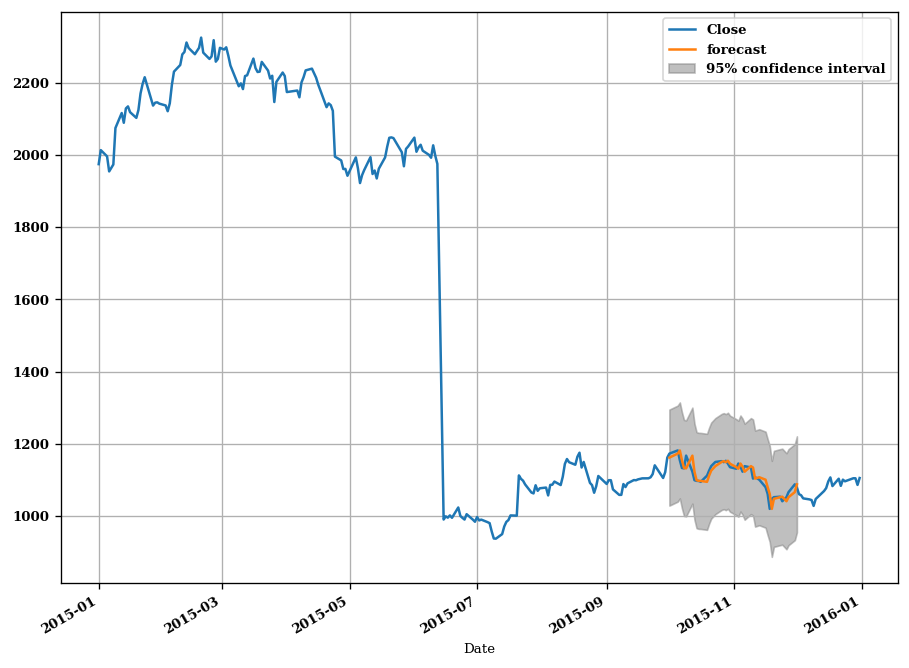

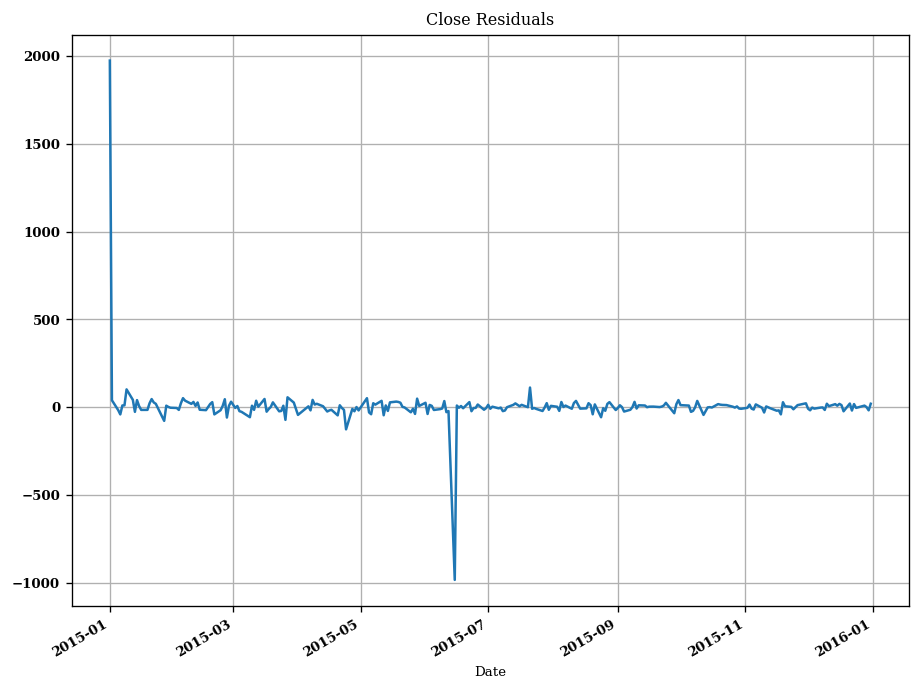

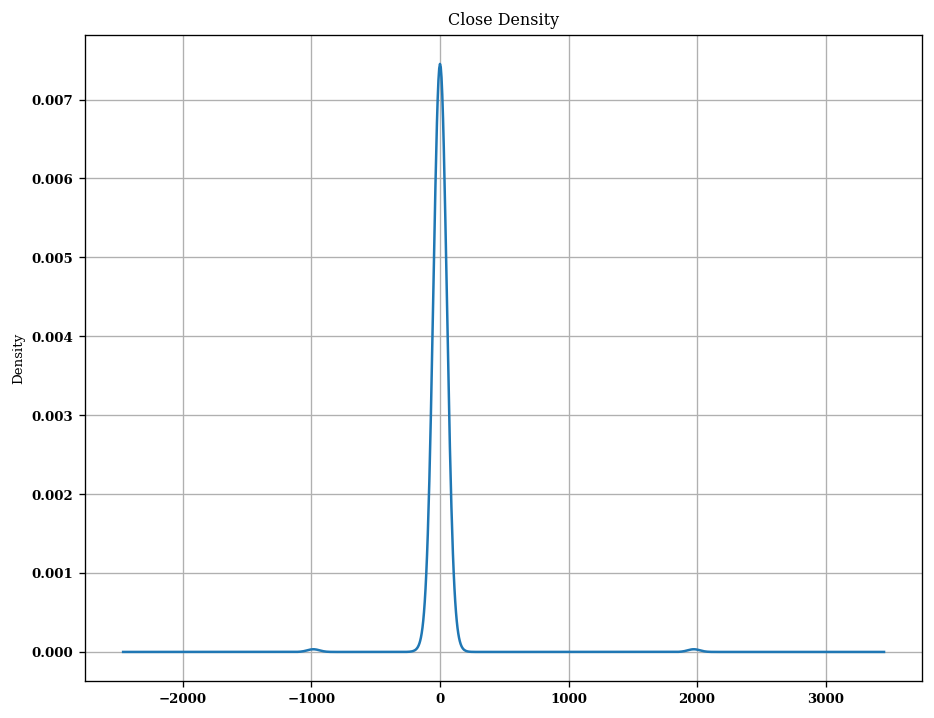

In [125]:
######################################################### ARIMA #######################################################################
forcast_infy_stock = infy_stock_df.copy() ## Copy the data in forcast variable
# # Show ARIMA Results 
res_arima_infy_stock = show_arima(forcast_infy_stock, train_rate, True, days_num,forcast_infy_stock.columns.values[0])


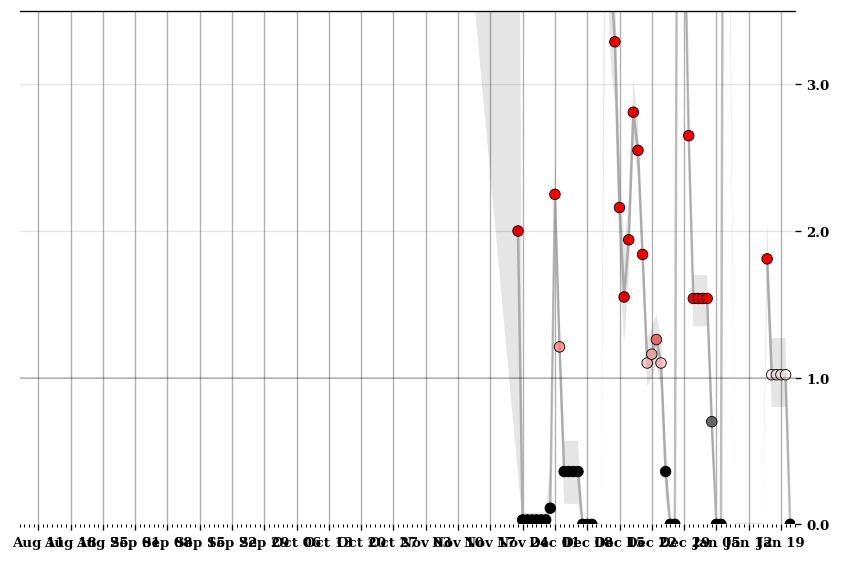

In [129]:
####################################################### Plot R effective #################################################################
####################################################### Plot Rt for ARIMA #################################################################
# # # ARIMA Prepare Data
NewCases_arima_df = prepare_arima_newCases(res_arima_infy_stock, days_num, '2015-11-23')
# # ## ARIMA Plot Rt
original, smoothed = prepare_cases(NewCases_arima_df)
posteriors = get_posteriors(smoothed)
hdis = highest_density_interval(posteriors)
most_likely = posteriors.idxmax().rename('ML')
result = pd.concat([most_likely, hdis], axis=1)
fig, ax = plt.subplots(figsize=(600/72,400/72))
plot_rt(result, ax)
ax.set_ylim(0.0,3.5)
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.show()


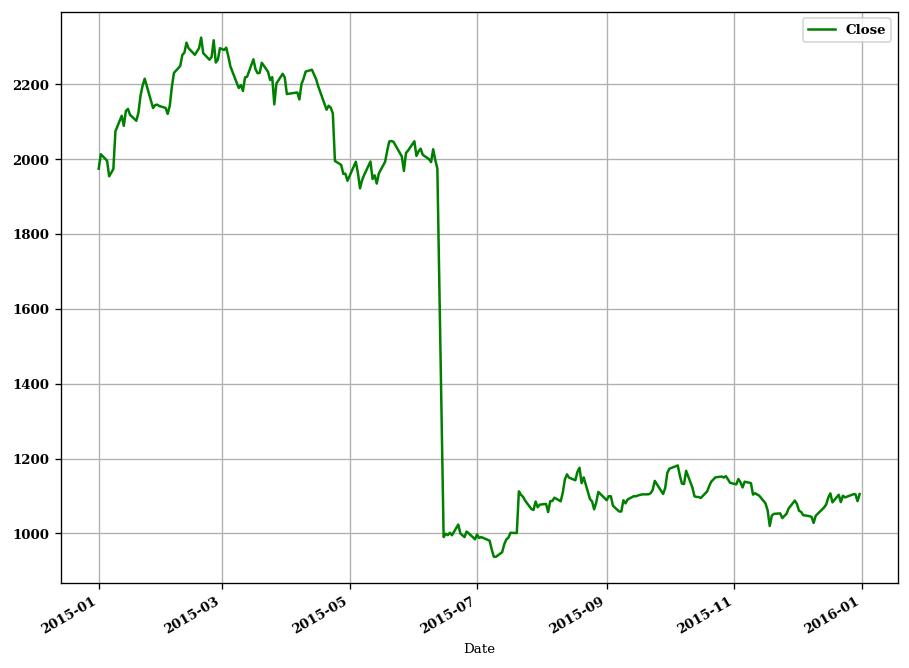

In [62]:

######################################################### LSTM - RNN #######################################################################
split = len(forcast_infy_stock)
ax = plt.gca()
forcast_infy_stock.plot(kind='line', y='Close', color ='g', ax=ax, use_index = True)
plt.show()

C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,340 (181.02 KB)

 Trainable params: 23,169 (90.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 23,171 (90.52 KB)

None


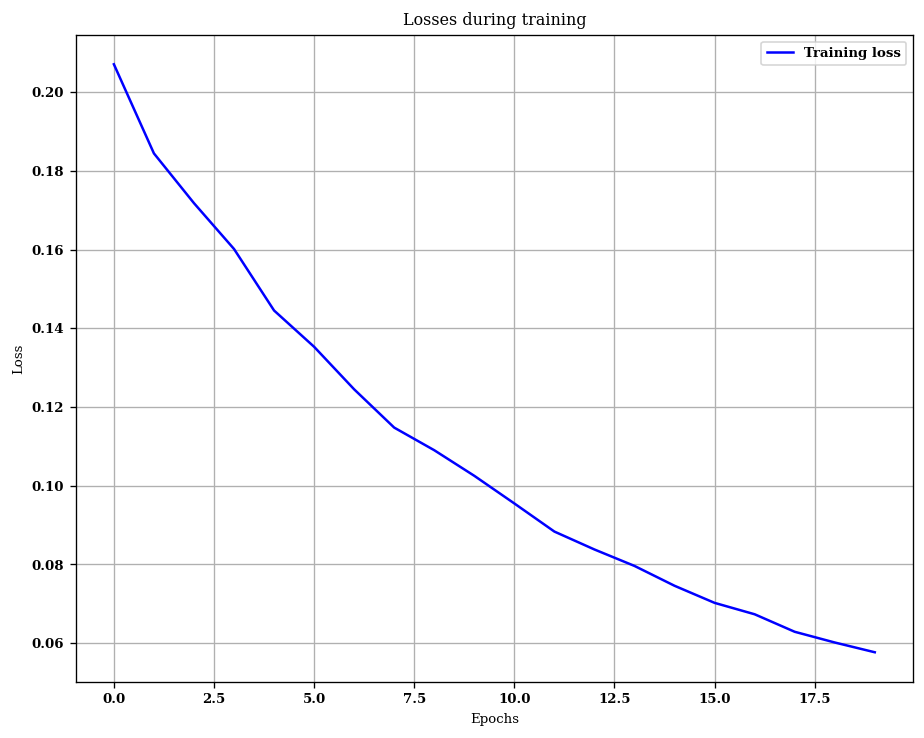

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


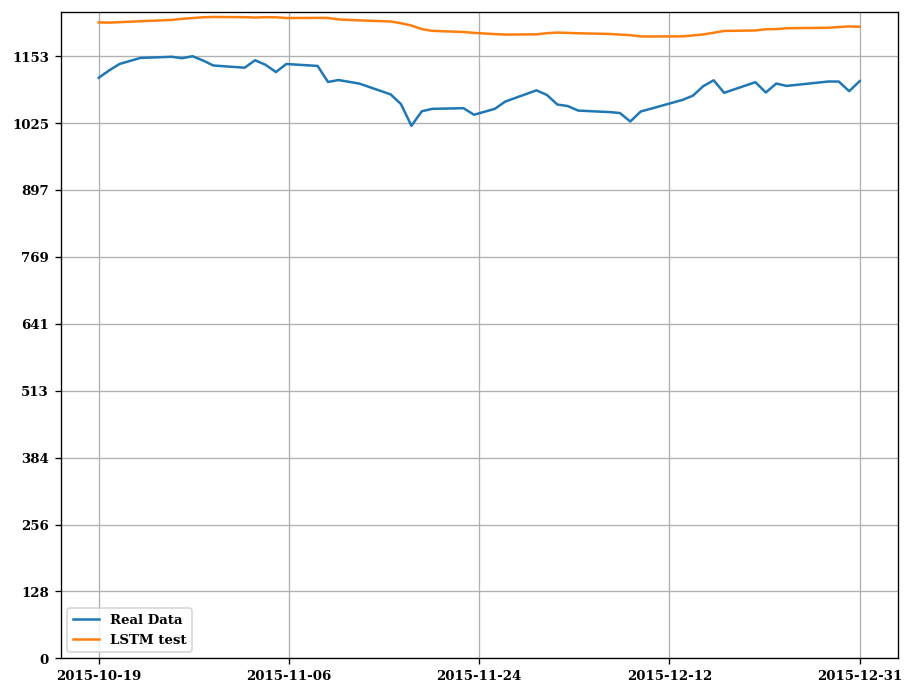

>>> Close LSTM Results MSE = 14424.56154 RMSE = 120.10230 MSLE = 0.01109 RMSLE = 0.10533 MAE = 116.79696 MAPE = 10.81651


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


C:\Users\licho\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


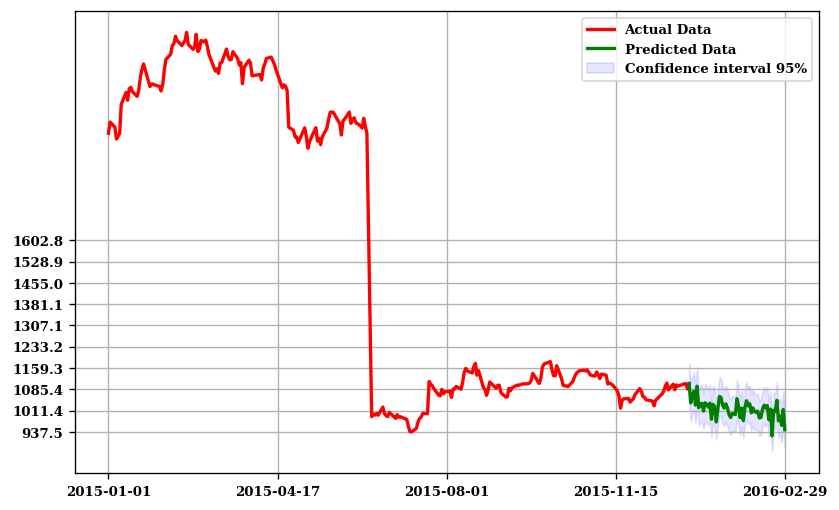

In [47]:
######################################################### Show Results #####################################################################
# 
# Metrics
res_lstm_infy_stock, mse, rmse, msle, rmsle, mae, mape = evaluate_lstm(forcast_infy_stock,train_rate,lstm_size)
print('>>>', forcast_infy_stock.columns.values[0], 'LSTM Results MSE = %.5f RMSE = %.5f MSLE = %.5f RMSLE = %.5f MAE = %.5f MAPE = %.5f' % (mse, rmse, msle, rmsle, mae, mape))
# Results
res_lstm_infy_stock = show_lstm(forcast_infy_stock, train_rate, lstm_size, days_num, forcast_infy_stock.columns.values[0])
split = len(forcast_infy_stock)
plot2series(res_lstm_infy_stock, split, forcast_infy_stock.columns.values[0]) ## Plot results 
